In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import numpy as np
from numpy.fft import fft2, fftshift, fftfreq
import torch

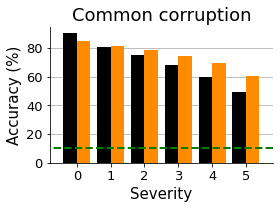

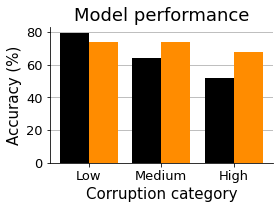

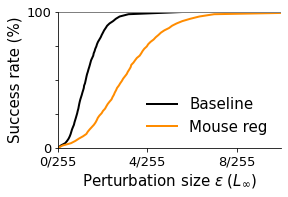

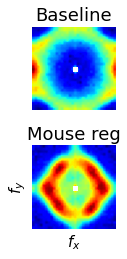

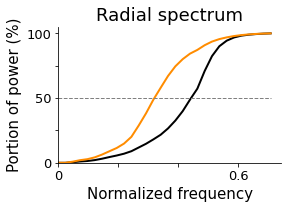

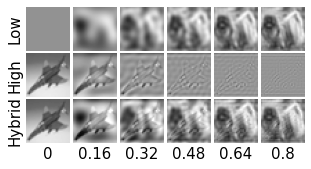

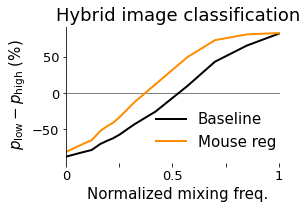

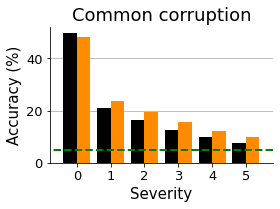

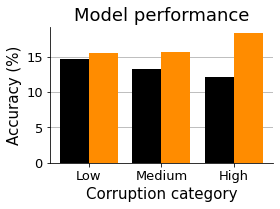

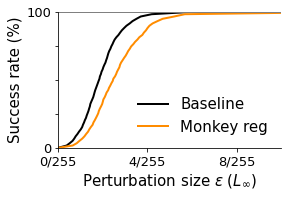

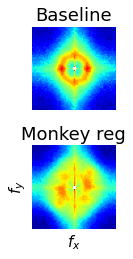

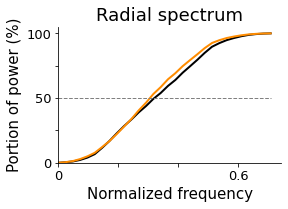

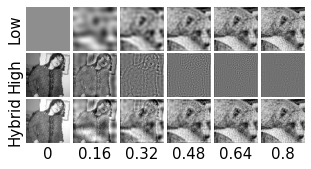

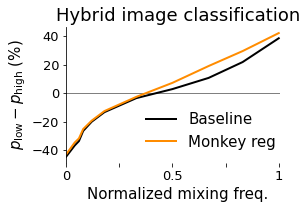

In [2]:
CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise',
    'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur',
    'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression',
]

for animal in ['mouse', 'monkey']:
    saved = torch.load(f'store/figs-data/{animal}_corruption.pt')
    colors = {
        'base': 'black',
        'neural': 'darkorange',
    }

    # fig 2a, c
    fig, ax = plt.subplots(figsize=(4, 2.5))
    xticks = np.arange(6)
    width = 0.4

    for i, label in enumerate(['base', 'neural']):
        accs = []
        for severity in range(6):
            if severity==0:
                accs.append(saved[label][0])
            else:
                accs.append(np.mean(saved[label][severity]))
        accs = np.array(accs)*100.
        ax.bar(xticks+(i-0.5)*width, accs, width=width, facecolor=colors[label], zorder=3)
    ax.set_xticks(xticks)
    ax.set_xlabel('Severity')
    if animal=='mouse':
        ax.set_yticks([0, 20, 40, 60, 80])
        base_acc = 10
    if animal=='monkey':
        ax.set_yticks([0, 20, 40])
        base_acc = 5
    ax.plot([-1, 6], base_acc*np.ones(2), color='green', linestyle='--', zorder=4)
    ax.set_xlim([-0.8, 5.8])
    ax.yaxis.grid()
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Common corruption')

    fig.savefig(f'store/figs/{animal}_corruption_robustness.svg')
    plt.show()
    
    
    # fig 3a, c
    fig, ax = plt.subplots(figsize=(4, 2.5))
    xticks = np.arange(3)
    width = 0.4

    for i, label in enumerate(['base', 'neural']):
        acc_low = np.mean([saved[label][severity][CORRUPTIONS.index(corruption)] for corruption in [
            'snow', 'frost', 'fog', 'brightness', 'contrast',
        ] for severity in range(1, 6)])
        acc_medium = np.mean([saved[label][severity][CORRUPTIONS.index(corruption)] for corruption in [
            'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur',
            'elastic_transform', 'pixelate', 'jpeg_compression',
        ] for severity in range(1, 6)])
        acc_high = np.mean([saved[label][severity][CORRUPTIONS.index(corruption)] for corruption in [
            'gaussian_noise', 'shot_noise', 'impulse_noise',
        ] for severity in range(1, 6)])
        accs = np.array([acc_low, acc_medium, acc_high])*100.
        ax.bar(xticks+(i-0.5)*width, accs, width=width, facecolor=colors[label], zorder=3)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['Low', 'Medium', 'High'])
    ax.set_xlabel('Corruption category')
    if animal=='mouse':
        ax.set_yticks([0, 20, 40, 60, 80])
    if animal=='monkey':
        ax.set_yticks([0, 5, 10, 15])
    ax.yaxis.grid()
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model performance')
    
    fig.savefig(f'store/figs/{animal}_corruption_breakdown.svg')
    plt.show()

    
    saved = torch.load(f'store/figs-data/{animal}_advs.pt')
    
    # fig 2b, d
    fig, ax = plt.subplots(figsize=(4, 2.5))

    qs = np.linspace(0, 1, 60)
    lines = []
    for i, label in enumerate(['base', 'neural']):
        diffs = saved['advs'][label]-saved['imgs'][label]
        dists = diffs.max(axis=(1, 2, 3))*255

        ds = np.quantile(dists, qs)
        h, = ax.plot(ds, qs*100, color=colors[label])
        lines.append(h)
    ax.plot([0, 10], [100, 100], linewidth=1, color='gray')
    ax.set_xlim([0, 10])
    ax.set_xticks([0, 4, 8])
    ax.set_xticklabels(['0/255', '4/255', '8/255'])
    ax.set_xlabel(r'Perturbation size $\epsilon$ ($L_\infty$)')
    ax.set_ylim([0, 100])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels(['0', None, None, None, '100'])
    ax.set_ylabel('Success rate (%)')
    if animal=='mouse':
        ax.legend(lines, ['Baseline', 'Mouse reg'], frameon=False)
    if animal=='monkey':
        ax.legend(lines, ['Baseline', 'Monkey reg'], frameon=False)
    fig.savefig(f'store/figs/{animal}_adv_dist.svg')
    plt.show()
    
    # fig 3b, d (insets)
    fig, axes = plt.subplots(2, 1, figsize=(1.5, 4))
    for i, label in enumerate(['base', 'neural']):
        diffs = saved['advs'][label]-saved['imgs'][label]
        diffs = diffs-np.mean(diffs, axis=(2, 3), keepdims=True)
        powers = np.abs(fft2(diffs))**2
        powers[..., 0, 0] = np.nan
        powers = fftshift(np.log(powers.mean(axis=(0, 1))))

        ax = axes[i]
        ax.imshow(powers, cmap='jet')
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        if label=='base':
            ax.set_title('Baseline')
        if label=='neural':
            if animal=='mouse':
                ax.set_title('Mouse reg')
            if animal=='monkey':
                ax.set_title('Monkey reg')
            ax.set_xlabel('$f_x$')
            ax.set_ylabel('$f_y$')
    fig.savefig(f'store/figs/{animal}_adv_fourier_maps.svg')
    plt.show()

    fx, fy = np.meshgrid(fftfreq(powers.shape[0]), fftfreq(powers.shape[1]))
    freqs = fftshift((fx**2+fy**2)**0.5)

    # fig 3b, d
    fig, ax = plt.subplots(figsize=(4, 2.5))
    alphas = np.linspace(0, freqs.max(), 30)
    for i, label in enumerate(['base', 'neural']):
        diffs = saved['advs'][label]-saved['imgs'][label]
        diffs = diffs-np.mean(diffs, axis=(2, 3), keepdims=True)
        powers = np.abs(fft2(diffs))**2
        powers[..., 0, 0] = np.nan
        powers = fftshift(powers.mean(axis=(0, 1)))

        ratios = []
        for alpha in alphas:
            mask = freqs<=alpha
            ratios.append(np.nansum(powers[mask])/np.nansum(powers))
        ax.plot(alphas, np.array(ratios)*100, color=colors[label])
    ax.plot([0, freqs.max()], [50, 50], linestyle='--', color='gray', linewidth=1)
    ax.set_xlim([0, None])
    ax.set_xticks([0, 0.2, 0.4, 0.6])
    ax.set_xticklabels(['0', None, None, '0.6'])
    ax.set_xlabel('Normalized frequency')
    ax.set_ylim([0, None])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels(['0', None, '50', None, '100'])
    ax.set_ylabel('Portion of power (%)')
    ax.set_title('Radial spectrum')
    fig.savefig(f'store/figs/{animal}_adv_fourier_radial.svg')
    plt.show()
    
    # fig 4a, 9a
    saved = torch.load(f'store/figs-data/{animal}_einmon_imgs.pt')

    alphas = saved['alphas']
    imgs_low, imgs_high, imgs_mix = saved['imgs_low'], saved['imgs_high'], saved['imgs_mix']
    fig, axes = plt.subplots(3, 6, figsize=(5, 2.5), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
    for i, alpha in enumerate(alphas):
        ax = axes[0, i]
        ax.imshow(imgs_low[alpha], vmin=0, vmax=1, cmap='gray')
        ax = axes[1, i]
        ax.imshow(imgs_high[alpha][0], vmin=0, vmax=1, cmap='gray')
        ax = axes[2, i]
        ax.imshow(imgs_mix[alpha], vmin=0, vmax=1, cmap='gray')
        ax.set_xlabel('{:g}'.format(alpha/100))
    for ax in axes.ravel():
        for s in ax.spines.values():
            s.set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
    axes[0, 0].set_ylabel('Low')
    axes[1, 0].set_ylabel('High')
    axes[2, 0].set_ylabel('Hybrid')
    fig.savefig(f'store/figs/{animal}_einmon_imgs.svg')
    plt.show()
     
    # fig 4b, 9b
    saved = torch.load(f'store/figs-data/{animal}_einmon_accs.pt')
    
    fig, ax = plt.subplots(figsize=(4, 2.5))
    lines = []
    for label in ['base', 'neural']:
        alphas = np.array(saved['alphas'][label])/100
        accs_mean = [(np.array(saved['accs_low'][label][i])-np.array(saved['accs_high'][label][i])).mean() for i in range(len(alphas))]
        h, = ax.plot(alphas, np.array(accs_mean)*100, color=colors[label])
        lines.append(h)
    ax.plot([0, 1], [0, 0], linewidth=1, color='gray', zorder=1)
    ax.set_xlim([0, None])
    ax.spines['bottom'].set_visible(False)
    ax.set_xlabel('Normalized mixing freq.')
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticklabels(['0', None, '0.5', None, '1'])
    ax.set_ylabel(r'$p_\mathrm{low}-p_\mathrm{high}$ (%)')
    if animal=='mouse':
        ax.legend(lines, ['Baseline', 'Mouse reg'], frameon=False)
    if animal=='monkey':
        ax.legend(lines, ['Baseline', 'Monkey reg'], frameon=False)
    ax.set_title('Hybrid image classification')
    fig.savefig(f'store/figs/{animal}_einmon_accs.svg')
    plt.show()

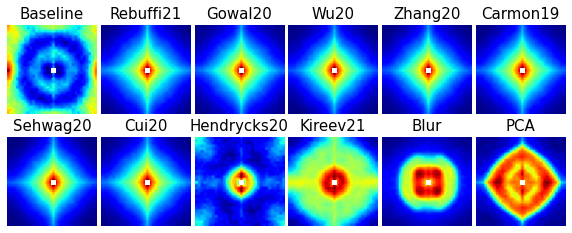

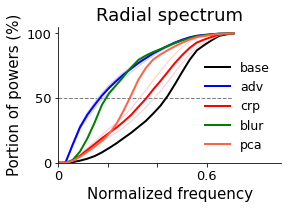

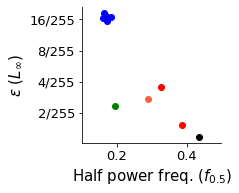

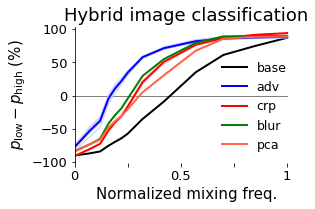

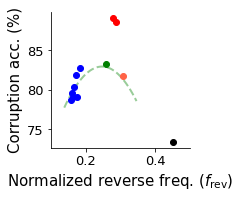

In [3]:
from matplotlib.colors import to_rgb

saved = torch.load('store/figs-data/CIFAR10_advs.pt')
logps = saved['logps']
dists = saved['dists']

groups = {
    'base': ['Baseline'],
    'adv': [
        'Rebuffi21', 'Gowal20', 'Wu20', 'Zhang20', 'Carmon19', 'Sehwag20', 'Cui20',
    ],
    'crp': [
        'Hendrycks20', 'Kireev21',
    ],
    'blur': ['Blur'],
    'pca': ['PCA'],
}
colors = {
    'base': to_rgb('black'),
    'adv': to_rgb('blue'),
    'crp': to_rgb('red'),
    'blur': to_rgb('green'),
    'pca': to_rgb('tomato'),
}

img_size = 32
fx, fy = np.meshgrid(fftfreq(img_size), fftfreq(img_size))
freqs = fftshift((fx**2+fy**2)**0.5)

alphas = np.linspace(0, freqs.max(), 25)
ratios = {}
half_freqs = {}
for label in logps:
    powers = np.exp(logps[label])
    ratios[label] = []
    for alpha in alphas:
        mask = freqs<=alpha
        ratios[label].append(np.nansum(powers[mask])/np.nansum(powers))
    ratios[label] = np.array(ratios[label])*100
    half_freqs[label] = np.interp(50, ratios[label], alphas)

# fig 5a
labels = [
    'Baseline', 'Rebuffi21', 'Gowal20', 'Wu20', 'Zhang20', 'Carmon19',
    'Sehwag20', 'Cui20', 'Hendrycks20', 'Kireev21', 'Blur', 'PCA',
]
fig, axes = plt.subplots(2, 6, figsize=(10, 4), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for label, ax in zip(labels, axes.ravel()):
    logp = logps[label]
    ax.imshow(logp, cmap='jet')
    ax.axis('off')
    ax.set_title(label, fontsize='medium')
fig.savefig(f'store/figs/CIFAR10_adv_spectrum.svg')

# fig 5b
fig, ax = plt.subplots(figsize=(4, 2.5))
lines, legends = [], []
for cat in groups:
    if len(groups[cat])==1:
        label = groups[cat][0]
        h, = ax.plot(alphas, ratios[label], color=colors[cat])
        lines.append(h)
        legends.append(cat)
    else:
        ratios_mean = []
        for label in groups[cat]:
            ratios_mean.append(ratios[label])
            ax.plot(alphas, ratios[label], color=np.array(colors[cat])*0.2+0.8, linewidth=1)
        ratios_mean = np.mean(ratios_mean, axis=0)
        h, = ax.plot(alphas, ratios_mean, color=colors[cat])
        lines.append(h)
        legends.append(cat)
ax.plot([0, 0.7], [50, 50], linestyle='--', color='gray', linewidth=1, zorder=1)
ax.legend(lines, legends, frameon=False, fontsize='small')
ax.set_xlim([0, 0.9])
ax.set_xticks([0, 0.2, 0.4, 0.6])
ax.set_xticklabels(['0', None, None, '0.6'])
ax.set_xlabel('Normalized frequency')
ax.set_ylim([0, None])
ax.set_yticks([0, 50, 100])
ax.set_ylabel('Portion of powers (%)')
ax.set_title('Radial spectrum')
fig.savefig(f'store/figs/CIFAR10_adv_radial.svg')

# fig 5c
fig, ax = plt.subplots(figsize=(2.5, 2.5))
for cat in groups:
    for label in groups[cat]:
        ax.scatter(half_freqs[label], np.log(np.mean(dists[label])), color=colors[cat])
ax.set_xlim([0.1, 0.5])
ax.set_xticks([0.2, 0.4])
ax.set_xlabel('Half power freq. ($f_{0.5}$)')
ax.set_yticks(np.log(np.array([2, 4, 8, 16])/255))
ax.set_yticklabels(['2/255', '4/255', '8/255', '16/255'])
ax.set_ylabel(r'$\epsilon$ ($L_\infty$)')
fig.savefig(f'store/figs/CIFAR10_adv_scatter.svg')
plt.show()

saved = torch.load(f'store/figs-data/CIFAR10_einmon_accs.pt')
accs_mean = {}
half_freqs = {}
for label in saved['alphas']:
    alphas = np.array(saved['alphas'][label])/100
    accs_mean[label] = [(np.array(saved['accs_low'][label][i])-np.array(saved['accs_high'][label][i])).mean() for i in range(len(alphas))]
    accs_mean[label] = np.array(accs_mean[label])*100
    half_freqs[label] = np.interp(0, accs_mean[label], alphas)

# fig 6a
fig, ax = plt.subplots(figsize=(4, 2.5))
lines, legends = [], []
for cat in groups:
    if len(groups[cat])==1:
        label = groups[cat][0]
        h, = ax.plot(alphas, accs_mean[label], color=colors[cat])
        lines.append(h)
        legends.append(cat)
    else:
        _accs_mean = []
        for label in groups[cat]:
            _accs_mean.append(accs_mean[label])
            ax.plot(alphas, accs_mean[label], color=np.array(colors[cat])*0.2+0.8, linewidth=1)
        _accs_mean = np.mean(_accs_mean, axis=0)
        h, = ax.plot(alphas, _accs_mean, color=colors[cat])
        lines.append(h)
        legends.append(cat)
ax.plot([0, 1], [0, 0], linewidth=1, color='gray', zorder=1)
ax.set_xlim([0, None])
ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Normalized mixing freq.')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels(['0', None, '0.5', None, '1'])
ax.set_ylabel(r'$p_\mathrm{low}-p_\mathrm{high}$ (%)')
ax.set_title('Hybrid image classification')
ax.legend(lines, legends, frameon=False, fontsize='small')
fig.savefig(f'store/figs/CIFAR10_einmon_accs.svg')
plt.show()

# fig 6b
fig, ax = plt.subplots(figsize=(2.5, 2.5))
for cat in groups:
    for label in groups[cat]:
        ax.scatter(half_freqs[label], saved['accs'][label]*100, color=colors[cat])

saved = torch.load(f'store/figs-data/CIFAR10-blur_einmon_accs.pt')
accs_mean = {}
half_freqs = []
accs_crp = []
for label in saved['alphas']:
    alphas = np.array(saved['alphas'][label])/100
    accs_mean[label] = [(np.array(saved['accs_low'][label][i])-np.array(saved['accs_high'][label][i])).mean() for i in range(len(alphas))]
    accs_mean[label] = np.array(accs_mean[label])*100
    half_freqs.append(np.interp(0, accs_mean[label], alphas))
    accs_crp.append(saved['accs'][label]*100)
half_freqs = np.array(half_freqs)
accs_crp = np.array(accs_crp)
p = np.polyfit(half_freqs, accs_crp, 2)
xs = np.linspace(np.min(half_freqs), np.max(half_freqs), 50)
ys = np.polyval(p, xs)
ax.plot(xs, ys, color=np.array(colors['blur'])*0.4+0.6, linestyle='--', zorder=0)
# ax.plot(half_freqs, accs_crp, color=np.array(colors['blur'])*0.4+0.6, linestyle='--', zorder=0)
ax.set_xlim([0.1, 0.5])
ax.set_xticks([0.2, 0.4])
ax.set_xlabel(r'Normalized reverse freq. ($f_\mathrm{rev}$)')
ax.set_ylabel('Corruption acc. (%)')
plt.show()